In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader

/u/kazumak2/.conda/envs/pytorch-env/lib/python3.9/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/zero-shot'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import create_sliding_windows, SequentialDeepONetDataset
from helper import load_model_experiment, convert2dim, train_val_test_split, fit, compute_metrics_region

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Load Model

In [3]:
#------------------------------
# Load model
#------------------------------
model_path = 'analysis/baseline/single_branch/lstm_window_30.pth'

model = load_model_experiment(model_path).to(device)

print(model)

Loaded model from analysis/baseline/single_branch/lstm_window_30.pth
SequentialDeepONet(
  (branch_net): LSTM(
    (lstm): LSTM(12, 128, num_layers=4, batch_first=True)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=128, out_features=128, bias=True)
  )
  (trunk_net): FCN(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)


## Load Datasets

In [4]:
#------------------------------
# Load test input function (unseen 2023 data)
# Load test target (resolution 1 deg)
#------------------------------
input_sensor = np.load('data/neutron_data_22yrs.npy')

# 1 degree target
output_1deg = np.load('data/dose_array.npy')

In [5]:
# data splitting keeping the consistency with training phase
train_input_1, train_target_1, val_input_1, val_target_1, test_input_1, test_target_1 = train_val_test_split(input_sensor, output_1deg)

# remove output_1deg and output_025deg from memory
del output_1deg

Train input shape: (4017, 12)
Validation input shape: (4018, 12)
Test input shape: (365, 12)


### Scaling

In [6]:
# input scaler
scaler = MinMaxScaler()

# the input data is common for both 1 deg and 0.25 deg targets
# so we fit the scaler only once using train_input_1
dummy = scaler.fit_transform(train_input_1)
test_input_1 = scaler.transform(test_input_1)

In [7]:
# check the mean of dummy (each channel)
print('Input data mean after scaling (each channel):', np.mean(dummy, axis=0))

# min and max of dummy (each channel)
print('Input data min after scaling (each channel):', np.min(dummy, axis=0))
print('Input data max after scaling (each channel):', np.max(dummy, axis=0))

Input data mean after scaling (each channel): [0.77234749 0.75856789 0.74168979 0.7234379  0.74022231 0.71411786
 0.71863942 0.91048404 0.72590877 0.71711673 0.53496759 0.54008107]
Input data min after scaling (each channel): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Input data max after scaling (each channel): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [8]:
# target data normalization (min-max scaling)
scaler_target_1 = MinMaxScaler()
train_target_1 = scaler_target_1.fit_transform(train_target_1)[..., np.newaxis]
test_target_1 = scaler_target_1.transform(test_target_1)[..., np.newaxis]

In [9]:
# location points for 1 degree target
trunk_1deg = np.load('data/grid_points.npy')

print('location range (1 deg):', np.min(trunk_1deg[:,0]), np.max(trunk_1deg[:,0]), np.min(trunk_1deg[:,1]), np.max(trunk_1deg[:,1]))

# Normalize trunk input
trunk_1deg[:, 0] = (trunk_1deg[:, 0] - np.min(trunk_1deg[:, 0])) / (np.max(trunk_1deg[:, 0]) - np.min(trunk_1deg[:, 0]))
trunk_1deg[:, 1] = (trunk_1deg[:, 1] - np.min(trunk_1deg[:, 1])) / (np.max(trunk_1deg[:, 1]) - np.min(trunk_1deg[:, 1]))

location range (1 deg): -90.0 90.0 -180.0 180.0


### Convert to Sequential Data

In [10]:
# Generate sequences for the testing set
test_input_seq_1, test_target_seq_1 = create_sliding_windows(test_input_1, test_target_1, window_size=30)

print('test_input_seq shape:', test_input_seq_1.shape)
print('test_target_seq shape:', test_target_seq_1.shape)

test_input_seq shape: torch.Size([336, 30, 12])
test_target_seq shape: torch.Size([336, 65341, 1])


## Sensor Information

In [11]:
import yaml
from helper import simulate_sensor_failure

In [12]:
with open('analysis/sensors/station_list.yaml', 'r') as file:
    station_info = yaml.safe_load(file)
    

# get station names and convert to a array
station_names = np.array([station['name'] for station in station_info['stations']])

print(station_names)

# get the sensor mean values
sensor_mean = np.mean(dummy, axis=0)

['ATHN' 'JUNG' 'NEWK' 'KERG' 'OULU' 'APTY' 'FSMT' 'INVK' 'NAIN' 'THUL'
 'SOPO' 'TERA']


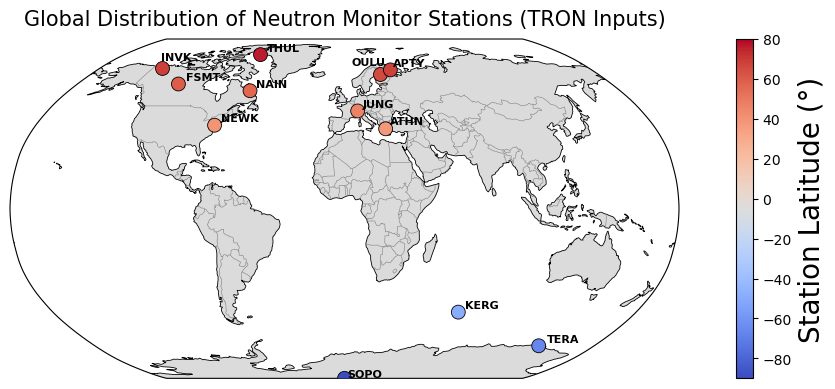

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ============================================================
# 1. Extract coordinates from YAML-parsed dictionary
# ============================================================
stations = station_info["stations"]

station_names = [s["name"] for s in stations]
lats = np.array([s["lat"] for s in stations])
lons = np.array([s["lon"] for s in stations])

# Normalize longitudes to [-180, 180] for consistent map wrapping
lons = (lons + 180) % 360 - 180

# ============================================================
# 2. Initialize map
# ============================================================
fig = plt.figure(figsize=(15, 4))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=0))
ax.set_global()

# Add base features
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="none", alpha=0.8)
ax.add_feature(cfeature.OCEAN, facecolor="white", alpha=1.0)
ax.coastlines(linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor="gray")

# ============================================================
# 3. Plot stations (color by latitude)
# ============================================================
cmap = plt.get_cmap("coolwarm")
norm = plt.Normalize(vmin=-90, vmax=80)  # covers your latitude range
colors = cmap(norm(lats))

sc = ax.scatter(lons, lats, c=lats, cmap=cmap, norm=norm, s=100,
                edgecolor="k", linewidth=0.6, transform=ccrs.PlateCarree(), zorder=3)

for i, name in enumerate(station_names):
    dx, dy = 3, 2  # default offset in degrees
    
    # Custom manual adjustments for overlapping or sensitive points
    if name == "OULU":
        dx, dy = -20, 5   # shift left and slightly up
    if name == "INVK":
        dx, dy = -10, 5  # shift left and down

    ax.text(lons[i] + dx, lats[i] + dy, name,
            fontsize=8, fontweight="bold", color="k",
            transform=ccrs.PlateCarree(), zorder=4)


# ============================================================
# 4. Add colorbar
# ============================================================
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.04)
cbar.set_label("Station Latitude (°)", fontsize=20)

# ============================================================
# 5. Final layout and save
# ============================================================
plt.title("Global Distribution of Neutron Monitor Stations (TRON Inputs)", fontsize=15, pad=10)
plt.tight_layout()
#plt.savefig("analysis/sensors/station_map.png", dpi=300, bbox_inches="tight")
plt.show()

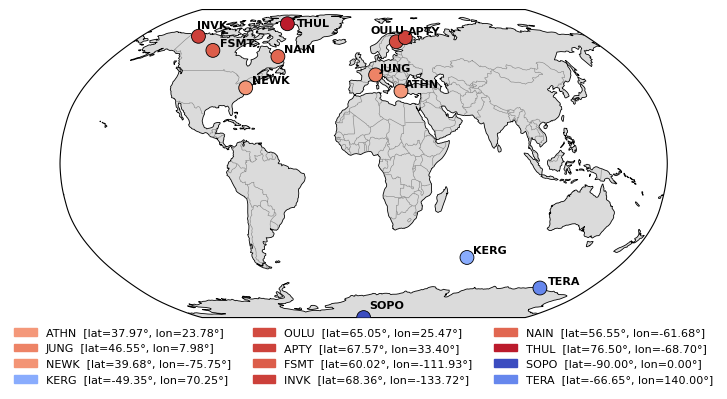

In [39]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(20, 4))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=0))
ax.set_global()

# Add base features
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="none", alpha=0.8)
ax.add_feature(cfeature.OCEAN, facecolor="white", alpha=1.0)
ax.coastlines(linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor="gray")

# ============================================================
# 3. Plot stations (color by latitude)
# ============================================================
cmap = plt.get_cmap("coolwarm")
norm = plt.Normalize(vmin=-90, vmax=80)  # covers your latitude range
colors = cmap(norm(lats))

sc = ax.scatter(lons, lats, c=lats, cmap=cmap, norm=norm, s=100,
                edgecolor="k", linewidth=0.6, transform=ccrs.PlateCarree(), zorder=3)

for i, name in enumerate(station_names):
    dx, dy = 3, 2  # default offset in degrees
    
    # Custom manual adjustments for overlapping or sensitive points
    if name == "OULU":
        dx, dy = -20, 5   # shift left and slightly up
    if name == "INVK":
        dx, dy = -10, 5  # shift left and down
    if name == "SOPO":
        dx, dy = 5, 10  # shift right and down
    if name == "THUL":
        dx, dy = 10, -2  # shift right and up

    ax.text(lons[i] + dx, lats[i] + dy, name,
            fontsize=8, fontweight="bold", color="k",
            transform=ccrs.PlateCarree(), zorder=4)


# ============================================================
# 3b. Create legend entries with color markers and lat/lon labels
# ============================================================
legend_elements = []

for i, name in enumerate(station_names):
    color = cmap(norm(lats[i]))
    label = f"{name}  [lat={lats[i]:.2f}°, lon={lons[i]:.2f}°]"
    patch = mpatches.Patch(color=color, label=label)
    legend_elements.append(patch)

# Place legend outside the map for clarity
ax.legend(handles=legend_elements,
          loc='lower center', bbox_to_anchor=(0.5, -0.25),
          ncol=3, fontsize=8, frameon=False,
          title="")


# ============================================================
# 5. Final layout and save
# ============================================================
#plt.title("Global Distribution of Neutron Monitor Stations (TRON Inputs)", fontsize=15, pad=10)
#plt.tight_layout()
plt.savefig("analysis/sensors/station_map_clean.png", dpi=300, bbox_inches="tight")
plt.show()

In [110]:
def simulate_and_evaluate_failure(sensor_index, replace_value=sensor_mean):
    print(f'Simulating failure for station: {station_names[sensor_index]} (index {sensor_index})')
    test_input_seq_failed = simulate_sensor_failure(test_input_seq_1, replace_value=replace_value, sensor_indices=[sensor_index])

    # create dataset and dataloader
    test_dataset_failed = SequentialDeepONetDataset(test_input_seq_failed, trunk_1deg, test_target_seq_1)
    test_loader_failed = DataLoader(test_dataset_failed, batch_size=32, shuffle=False)
    
    # prediction
    prediction, target = fit(model, test_loader_failed, device, scaler_target_1)
    
    lon_grid, lat_grid, pred = convert2dim(prediction)
    _, _, target = convert2dim(target)
    
    l2_error, ssim = compute_metrics_region(pred, target, lon_grid=lon_grid, lat_grid=lat_grid, region_extent=[-180, 180, -90, 90])
    
    return pred, target, l2_error, ssim

### Single Sensor Failure

In [111]:
rel_l2_list = []
ssim_list = []
for i in range(len(station_names)):
    pred, target, l2_error, ssim = simulate_and_evaluate_failure(sensor_index=i, replace_value=sensor_mean)
    rel_l2_list.append(l2_error)
    ssim_list.append(ssim)
  

rel_l2_array = np.array(rel_l2_list)
ssim_array = np.array(ssim_list)

Simulating failure for station: ATHN (index 0)
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.12958924
Mean SSIM: 0.9993253665791597
Simulating failure for station: JUNG (index 1)
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.24369857
Mean SSIM: 0.9993072470650313
Simulating failure for station: NEWK (index 2)
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.48442632
Mean SSIM: 0.9992475597918165
Simulating failure for station: KERG (index 3)
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.30730003
Mean SSIM: 0.9992910812940304
Simulating failure for station: OULU (index 4)
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.28300607
Mean SSIM: 0.9993004491535012
Simulating failure for station: APTY (index 5)
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.32603896
Mean SSIM: 0.9992893543078163
Simulating failure for station: FSMT (index 6)
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.35217702
Mean SSIM: 0.9992831219497873
Simulating failure for station: INVK (index 7)
Region [-180, 180, -90

['ATHN', 'JUNG', 'NEWK', 'KERG', 'OULU', 'APTY', 'FSMT', 'INVK', 'NAIN', 'THUL', 'SOPO', 'TERA']


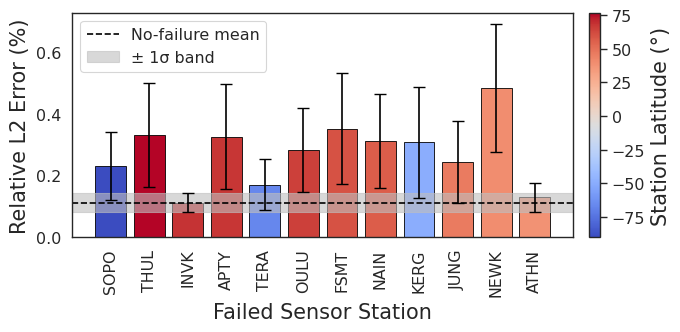

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================
# 1. Example inputs (replace these with your actual arrays)
# ==============================================================

print(station_names)

# latitude from station_info (yaml file)
lats = np.array([station['lat'] for station in station_info['stations']])
lons = np.array([station['lon'] for station in station_info['stations']])


base_error_mean = 0.112
base_error_std  = 0.031

# ==============================================================
# 2. Compute means and stds
# ==============================================================

means = [np.mean(r) for r in rel_l2_array]
stds  = [np.std(r) for r in rel_l2_array]

# Sort stations by geomagnetic latitude (descending absolute latitude)
order = np.argsort(-np.abs(lats))
station_names = [station_names[i] for i in order]
means = [means[i] for i in order]
stds = [stds[i] for i in order]
lats = [lats[i] for i in order]

# ==============================================================
# 3. Plot style (journal-grade)
# ==============================================================

sns.set_context("paper", font_scale=1.3)
sns.set_style("white")

fig, ax = plt.subplots(figsize=(7,3.5))

ax.grid(False)  

# Color mapping by latitude (polar=blue, equatorial=red)
cmap = plt.get_cmap("coolwarm")
colors = [cmap((lat - min(lats)) / (max(lats) - min(lats))) for lat in lats]

x = np.arange(len(station_names))
bars = ax.bar(x, means, yerr=stds, capsize=4,
              color=colors, edgecolor="k", linewidth=0.6)

# Baseline (no-failure) mean ± std band
# Replace your manual ax.text(...) line with this:
ax.axhline(base_error_mean, color='k', linestyle='--', lw=1.2,
            label='No-failure mean')
ax.axhspan(base_error_mean - base_error_std,
           base_error_mean + base_error_std,
           color='0.75', alpha=0.6, label='± 1σ band')

# Add legend outside or below the plot
ax.legend(loc='upper left')

# ==============================================================
# 4. Axis labels and layout
# ==============================================================

ax.set_xticks(x)
ax.set_xticklabels(station_names, rotation=90, ha='center')
ax.set_xlabel("Failed Sensor Station", fontsize=15)
ax.set_ylabel("Relative L2 Error (%)", fontsize=15)
#ax.set_ylim(0, 1.2)

# Add colorbar for latitude context
sm = plt.cm.ScalarMappable(cmap=cmap,
    norm=plt.Normalize(vmin=min(lats), vmax=max(lats)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.03)
cbar.set_label("Station Latitude (°)", fontsize=15)

# Final layout
#plt.title("TRON Robustness: Single-Station Outage Impact", fontsize=14, pad=15)
plt.tight_layout()

# ==============================================================
# 5. Save high-resolution output
# ==============================================================

plt.savefig("analysis/sensors/tron_single_station_failure.png", dpi=300, bbox_inches="tight")
plt.show()

### Two Sensor Failure

In [113]:
def simulate_and_evaluate_2failure(sensor_index_1, sensor_index_2, replace_value=sensor_mean):
    print(f'Simulating failure for stations: {station_names[sensor_index_1]} (index {sensor_index_1}) and {station_names[sensor_index_2]} (index {sensor_index_2})')
    test_input_seq_failed = simulate_sensor_failure(test_input_seq_1, replace_value=replace_value, sensor_indices=[sensor_index_1, sensor_index_2])

    # create dataset and dataloader
    test_dataset_failed = SequentialDeepONetDataset(test_input_seq_failed, trunk_1deg, test_target_seq_1)
    test_loader_failed = DataLoader(test_dataset_failed, batch_size=32, shuffle=False)
    
    # prediction
    prediction, target = fit(model, test_loader_failed, device, scaler_target_1)
    
    lon_grid, lat_grid, pred = convert2dim(prediction)
    _, _, target = convert2dim(target)
    
    l2_error, ssim = compute_metrics_region(pred, target, lon_grid=lon_grid, lat_grid=lat_grid, region_extent=[-180, 180, -90, 90])
    
    return pred, target, l2_error, ssim

In [114]:
import itertools

stations = station_info["stations"]
station_names = [s["name"] for s in stations]

num_sensors = len(station_names)

# Generate all unique (i, j) pairs, i < j
sensor_pairs = list(itertools.combinations(range(num_sensors), 2))

print(f"Total pairs: {len(sensor_pairs)}")
print(sensor_pairs[:5])  # check first few

print("pair station names:")
for i, j in sensor_pairs[:4]:
    print(f"({station_names[i]}, {station_names[j]})")

Total pairs: 66
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
pair station names:
(ATHN, JUNG)
(ATHN, NEWK)
(ATHN, KERG)
(ATHN, OULU)


In [115]:
# pair_results = []
# 
# for (i, j) in sensor_pairs[:]:
#     _, _, l2_error, ssim = simulate_and_evaluate_2failure(i, j, replace_value=sensor_mean)
#     pair_results.append({
#         "station_1": station_names[i],
#         "station_2": station_names[j],
#         "L2_error": l2_error,
#         "SSIM": ssim
#     })
#     
# # conver to numpy arrays
# rel_l2_array_2failure = np.array([res["L2_error"] for res in pair_results])
# ssim_array_2failure = np.array([res["SSIM"] for res in pair_results])

In [116]:
# save the results for future reference
#np.save('analysis/sensors/rel_l2_array_2failure.npy', rel_l2_array_2failure)
#np.save('analysis/sensors/ssim_array_2failure.npy', ssim_array_2failure)


rel_l2_array_2failure = np.load('analysis/sensors/rel_l2_array_2failure.npy')
ssim_array_2failure = np.load('analysis/sensors/ssim_array_2failure.npy')

In [117]:
# (66, 336) -> mean over 336 samples = (66,)
rel_l2_mean_2failure = np.mean(rel_l2_array_2failure, axis=1)
ssim_mean_2failure = np.mean(ssim_array_2failure, axis=1)

In [118]:
import numpy as np
import itertools

num_sensors = len(station_names)

# Initialize empty symmetric matrices
L2_mat = np.zeros((num_sensors, num_sensors))
SSIM_mat = np.zeros((num_sensors, num_sensors))

# Fill them with your averaged results
for k, (i, j) in enumerate(itertools.combinations(range(num_sensors), 2)):
    L2_mat[i, j] = rel_l2_mean_2failure[k]
    L2_mat[j, i] = rel_l2_mean_2failure[k]
    SSIM_mat[i, j] = ssim_mean_2failure[k]
    SSIM_mat[j, i] = ssim_mean_2failure[k]

# (optional) add single-station errors on diagonal if you have them
# np.fill_diagonal(L2_mat, rel_l2_single)
# np.fill_diagonal(SSIM_mat, ssim_single)


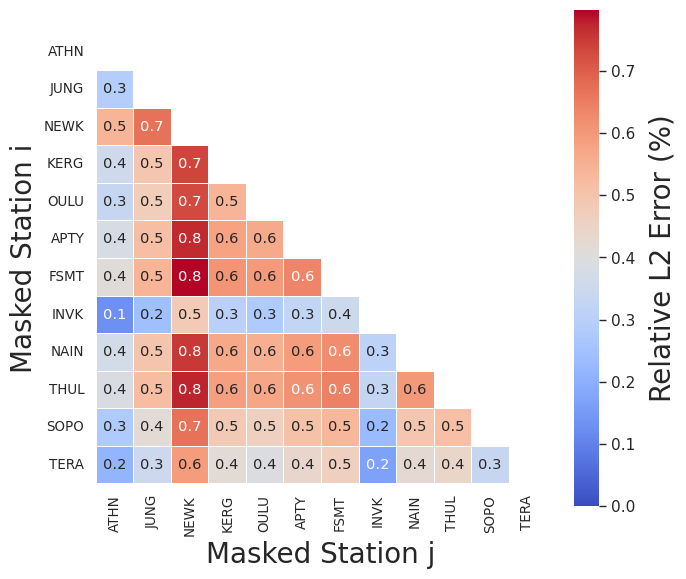

In [119]:
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# 1. Construct pairwise matrix (using your mean results)
# ============================================================
num_sensors = len(station_names)

L2_mat = np.zeros((num_sensors, num_sensors))
for k, (i, j) in enumerate(itertools.combinations(range(num_sensors), 2)):
    L2_mat[i, j] = rel_l2_mean_2failure[k]
    L2_mat[j, i] = rel_l2_mean_2failure[k]

L2_plot = L2_mat.copy()
np.fill_diagonal(L2_plot, np.nan)  # blank diagonal

# ============================================================
# 2. Mask for upper triangle
# ============================================================
mask = np.triu(np.ones_like(L2_plot, dtype=bool))

# ============================================================
# 3. Plot heatmap (lower triangle only)
# ============================================================
sns.set_context("paper", font_scale=1.1)
sns.set_style("white")

fig, ax = plt.subplots(figsize=(7,6))

sns.heatmap(L2_plot, mask=mask, cmap="coolwarm", square=True,
            xticklabels=station_names, yticklabels=station_names,
            cbar_kws={'label': 'Relative L2 Error (%)'},
            linewidths=0.4, linecolor='white',
            vmin=0, vmax=np.nanmax(L2_plot),
            annot=True, fmt=".1f")

# Make colorbar label larger
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=11)
cbar.set_label("Relative L2 Error (%)", fontsize=20, labelpad=10)

# ============================================================
# 5. Final touches
# ============================================================
#ax.set_title("Pairwise Station-Outage Sensitivity (L₂)", pad=10)
ax.set_xlabel("Masked Station j", fontsize=20)
ax.set_ylabel("Masked Station i", fontsize=20)
plt.xticks(rotation=90, ha='center')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("analysis/sensors/pairwise_l2_error.png", dpi=300, bbox_inches="tight")
plt.show()


### More Sensor Fialure (1 sensor active)

In [120]:
def simulate_multiple_sensor_failure(input_seq, replace_value, keep_idx):
    # Create list of all sensors except this one
    mask_indices = [i for i in range(12) if i != keep_idx]

    test_input_seq_failed = simulate_sensor_failure(
        input_seq=input_seq,
        replace_value=replace_value,  # scalar (e.g., 0.5) or per-sensor array
        sensor_indices=mask_indices
    )
    
    dataset_failed = SequentialDeepONetDataset(test_input_seq_failed, trunk_1deg, test_target_seq_1)
    test_loader_failed = DataLoader(dataset_failed, batch_size=32, shuffle=False)
    
    # prediction
    prediction, target = fit(model, test_loader_failed, device, scaler_target_1)
    
    lon_grid, lat_grid, pred = convert2dim(prediction)
    _, _, target = convert2dim(target)
    
    l2_error, ssim = compute_metrics_region(pred, target, lon_grid=lon_grid, lat_grid=lat_grid, region_extent=[-180, 180, -90, 90])
    
    return pred, target, l2_error, ssim

In [128]:
l2_error_list = []
ssim_list = []

for keep_idx in range(len(station_names)):
    print(station_names[keep_idx])
    pred, target, l2_error, ssim = simulate_multiple_sensor_failure(test_input_seq_1, replace_value=sensor_mean, keep_idx=keep_idx)
    l2_error_list.append(l2_error)
    ssim_list.append(ssim)
    
single_l2_error_array = np.array(l2_error_list)
single_ssim_array = np.array(ssim_list)

ATHN
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 2.4058893
Mean SSIM: 0.9973918245421455
JUNG
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 2.3133247
Mean SSIM: 0.9975452065670284
NEWK
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 2.0907953
Mean SSIM: 0.9978142286306845
KERG
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 2.2621272
Mean SSIM: 0.99762751626606
OULU
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 2.253742
Mean SSIM: 0.9976053777991429
APTY
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 2.223509
Mean SSIM: 0.9976546641541468
FSMT
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 2.2043414
Mean SSIM: 0.9976802931814641
INVK
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 2.4538538
Mean SSIM: 0.9973155163179799
NAIN
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 2.2465785
Mean SSIM: 0.997618885833584
THUL
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 2.222965
Mean SSIM: 0.9976580795317622
SOPO
Region [-180, 180, -90, 90]
Mean rel-L2 (%): 2.3140764
Mean SSIM: 0.997523569672843
TERA
Region [-180

['ATHN', 'JUNG', 'NEWK', 'KERG', 'OULU', 'APTY', 'FSMT', 'INVK', 'NAIN', 'THUL', 'SOPO', 'TERA']


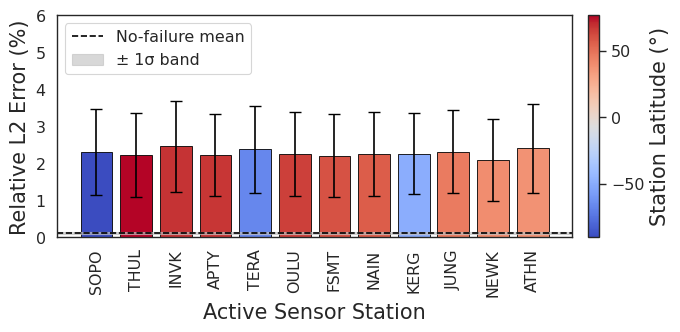

In [143]:
#==============================================================
# 1. Example inputs (replace these with your actual arrays)
# ==============================================================
stations = station_info["stations"]
station_names = [s["name"] for s in stations]
print(station_names)

# latitude from station_info (yaml file)
lats = np.array([station['lat'] for station in station_info['stations']])
lons = np.array([station['lon'] for station in station_info['stations']])


base_error_mean = 0.112
base_error_std  = 0.031

# ==============================================================
# 2. Compute means and stds
# ==============================================================

means = [np.mean(r) for r in single_l2_error_array]
stds  = [np.std(r) for r in single_l2_error_array]

# Sort stations by geomagnetic latitude (descending absolute latitude)
order = np.argsort(-np.abs(lats))
station_names = [station_names[i] for i in order]
means = [means[i] for i in order]
stds = [stds[i] for i in order]
lats = [lats[i] for i in order]

# ==============================================================
# 3. Plot style (journal-grade)
# ==============================================================

sns.set_context("paper", font_scale=1.3)
sns.set_style("white")

fig, ax = plt.subplots(figsize=(7,3.5))

ax.grid(False)  

# Color mapping by latitude (polar=blue, equatorial=red)
cmap = plt.get_cmap("coolwarm")
colors = [cmap((lat - min(lats)) / (max(lats) - min(lats))) for lat in lats]

x = np.arange(len(station_names))
bars = ax.bar(x, means, yerr=stds, capsize=4,
              color=colors, edgecolor="k", linewidth=0.6)

# Baseline (no-failure) mean ± std band
# Replace your manual ax.text(...) line with this:
ax.axhline(base_error_mean, color='k', linestyle='--', lw=1.2,
            label='No-failure mean')
ax.axhspan(base_error_mean - base_error_std,
           base_error_mean + base_error_std,
           color='0.75', alpha=0.6, label='± 1σ band')

# Add legend outside or below the plot
ax.legend(loc='upper left')

# ==============================================================
# 4. Axis labels and layout
# ==============================================================

ax.set_xticks(x)
ax.set_xticklabels(station_names, rotation=90, ha='center')
ax.set_xlabel("Active Sensor Station", fontsize=15)
ax.set_ylabel("Relative L2 Error (%)", fontsize=15)
ax.set_ylim(0, 6)

# Add colorbar for latitude context
sm = plt.cm.ScalarMappable(cmap=cmap,
    norm=plt.Normalize(vmin=min(lats), vmax=max(lats)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.03)
cbar.set_label("Station Latitude (°)", fontsize=15)

# Final layout
#plt.title("TRON Robustness: Single-Station Outage Impact", fontsize=14, pad=15)
plt.tight_layout()

# ==============================================================
# 5. Save high-resolution output
# ==============================================================

plt.savefig("analysis/sensors/tron_single_station_active.png", dpi=300, bbox_inches="tight")
plt.show()

## Dataset & DataLoader

In [122]:
# Create DataLoader for test set
test_dataset_1 = SequentialDeepONetDataset(test_input_seq_1, trunk_1deg, test_target_seq_1)
test_loader_1 = DataLoader(test_dataset_1, batch_size=1, shuffle=False)

## Prediction

In [123]:
predictions_1deg, targets_1deg = fit(model, test_loader_1, device, scaler_target_1)
print('predictions shape:', predictions_1deg.shape)
print('targets shape:', targets_1deg.shape)

predictions shape: (336, 65341, 1)
targets shape: (336, 65341, 1)


In [124]:
lon_grid_1, lat_grid_1, pred_img_1 = convert2dim(predictions_1deg)  # (N,H,W)
_,        _,        targ_img_1 = convert2dim(targets_1deg)      # (N,H,W)

# print pred sizes
print('1 deg pred_img shape:', pred_img_1.shape)
print('1 deg targ_img shape:', targ_img_1.shape)

1 deg pred_img shape: (336, 181, 361)
1 deg targ_img shape: (336, 181, 361)


In [125]:
l2_error, ssim = compute_metrics_region(pred_img_1, targ_img_1, lon_grid=lon_grid_1, lat_grid=lat_grid_1, region_extent=[-180, 180, -90, 90])

Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.1122214
Mean SSIM: 0.9993283702437078
